<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/JACDID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.5.2 is successfully installed


In [2]:
!pip install colorama

In [3]:
import cv2
import sys
import albumentations as A
from albumentations.pytorch import ToTensor
from itertools import groupby
import torch
import torch.nn.functional as F
from colorama import Fore
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
from random import shuffle
from glob import glob
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive

In [5]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!ls -lrt /content/gdrive/MyDrive/ID-crops.tgz

-rw------- 1 root root 47138662 Apr 29 00:48 /content/gdrive/MyDrive/ID-crops.tgz


In [7]:
!cp /content/gdrive/MyDrive/ID-crops.tgz .

In [8]:
!tar -zxvf ID-crops.tgz

crops/
crops/cubanc_35_1_01281467ta140_id.png
crops/cubanc_35_1_01281471ta_199_id.png
crops/cubanc_35_1_01281464ta136_id.png
crops/cubanc_35_1_01281468ta34_id.png
crops/cubanc_35_1_01281452ta_148_id.png
crops/cubanc_35_1_01281464ta29_id.png
crops/cubanc_35_1_01281470ta139_id.png
crops/cubanc_35_1_01281465ta87_id.png
crops/cubanc_35_1_01281464ta192_id.png
crops/cubanc_35_1_01281467ta176_id.png
crops/cubanc_35_1_01281469ta_0_id.png
crops/cubanc_35_1_01281470ta129_id.png
crops/cubanc_35_1_01281465ta63_id.png
crops/cubanc_35_1_01281471ta_159_id.png
crops/cubanc_35_1_01281465ta108_id.png
crops/cubanc_35_1_01281470ta132_id.png
crops/cubanc_35_1_01281464ta134_id.png
crops/cubanc_35_1_01281471ta_114_id.png
crops/cubanc_35_1_01281452ta_187_id.png
crops/cubanc_35_1_01281464ta46_id.png
crops/cubanc_35_1_01281467ta130_id.png
crops/cubanc_35_1_01281462ta70_id.png
crops/cubanc_35_1_01281471ta_158_id.png
crops/cubanc_35_1_01281466ta49_id.png
crops/cubanc_35_1_01281471ta_80_id.png
crops/cubanc_35_1_01

In [9]:
img = cv2.imread("crops/cubanc_35_1_01281468ta2_id.png", cv2.IMREAD_GRAYSCALE)

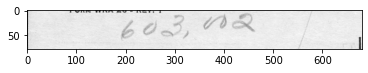

In [10]:
plt.imshow(img, cmap="gray")

In [11]:
!ls -lrt

total 46156
drwxrwxr-x 2 1000 1000   114688 Apr 19 01:01 crops
drwxr-xr-x 1 root root     4096 Apr 21 13:39 sample_data
drwx------ 6 root root     4096 Apr 29 00:51 gdrive
-rw------- 1 root root 47138662 Apr 29 02:27 ID-crops.tgz


In [12]:
files = glob('crops/*.png')
print(f'{len(files)} files found')

1904 files found


In [13]:
shuffle(files)

In [14]:
tnum = int(0.75 * len(files))
tnum

1428

In [15]:
train_files = files[:tnum]
test_files = files[tnum:]

In [16]:
class WRAIDDataset(Dataset): 
    def __init__(self, files, transform=None):
        self.files = files
        self.map = {"01281452ta": 600000,
                    "01281462ta": 600800,
                    "01281463ta": 602000,
                    "01281464ta": 602200,
                    "01281465ta": (602400, (96, -1)),
                    "01281466ta": 602600,
                    "01281467ta": 602800,
                    "01281468ta": 603000,
                    "01281469ta": 603200,
                    "01281470ta": 603400,
                    "01281471ta": 603600
                   }
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        file = self.files[index]
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 28), cv2.INTER_LINEAR)
        parts = file.split('_')
        
        if len(parts) == 5:
            num = parts[3].split('ta')[-1]
            key = parts[3].split('ta')[0] + 'ta'
        else:
            assert(len(parts) == 6)
            num = parts[4]
            key = parts[3]
        
        num = int(num)
        val = self.map[key]
        if isinstance(val, tuple):
            base = val[0]
            entry = val[1]
            cutoff, adj = entry
            if num >= cutoff:
                # print(f'{num} over {cutoff}, applying {adj}')
                ID = base + num + adj
            else:
                ID = base + num
        else:
            base = val
            ID = base + num
            
        ID = str(ID)
        ID = ID[:3] + ',' + ID[3:]
        label = torch.IntTensor(7).fill_(0)
        for k in range(7):
            if ID[k].isdigit():
                label[k] = int(ID[k])
            else:
                label[k] = 10
        
        if self.transform:
            image = self.transform(image=image)['image']

        return (image, label)

In [17]:
def statX(inp):
    print(f'min={inp.min():.2f}, max={inp.max():.2f}, mean={inp.mean():.2f}, var={inp.var():.2f}, std={inp.std():.2f}')

In [18]:
train_transform = A.Compose([
    #A.ShiftScaleRotate(shift_limit=0A.0625, scale_limit=0.50, rotate_limit=5, p=.75),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=3, p=.75),
    A.OpticalDistortion(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensor(),
])

In [19]:
train_set = WRAIDDataset(train_files, train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

In [20]:
data = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  0, 10,  1,  8,  1], dtype=torch.int32)
min=-0.51, max=0.68, mean=0.58, var=0.00, std=0.06


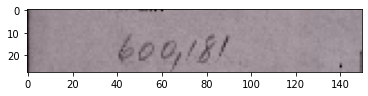

tensor([ 6,  0,  0, 10,  8,  4,  4], dtype=torch.int32)
min=0.26, max=0.73, mean=0.67, var=0.00, std=0.05


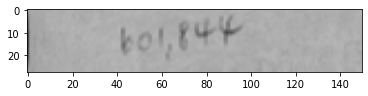

tensor([ 6,  0,  2, 10,  8,  2,  0], dtype=torch.int32)
min=-0.25, max=0.62, mean=0.48, var=0.01, std=0.10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


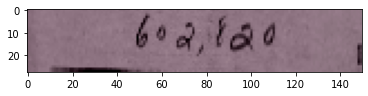

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  3, 10,  1,  6,  9], dtype=torch.int32)
min=-0.72, max=0.74, mean=0.61, var=0.03, std=0.16


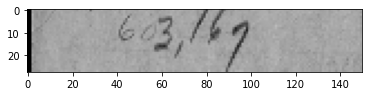

tensor([ 6,  0,  3, 10,  2,  9,  6], dtype=torch.int32)
min=-0.47, max=0.94, mean=0.80, var=0.03, std=0.17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


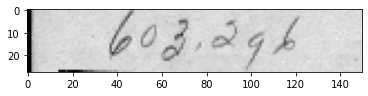

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  0, 10,  0,  9,  0], dtype=torch.int32)
min=-0.11, max=0.75, mean=0.68, var=0.00, std=0.06


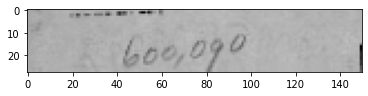

tensor([ 6,  0,  2, 10,  7,  8,  5], dtype=torch.int32)
min=0.11, max=0.79, mean=0.69, var=0.01, std=0.07


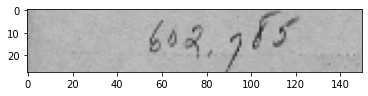

tensor([ 6,  0,  3, 10,  0,  4,  6], dtype=torch.int32)
min=0.55, max=0.80, mean=0.74, var=0.00, std=0.03


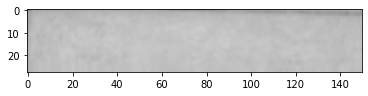

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  0, 10,  1,  4,  1], dtype=torch.int32)
min=-0.09, max=0.75, mean=0.66, var=0.00, std=0.06


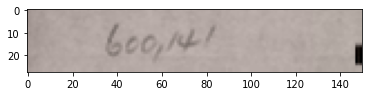

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  2, 10,  4,  2,  2], dtype=torch.int32)
min=-0.52, max=0.84, mean=0.73, var=0.02, std=0.16


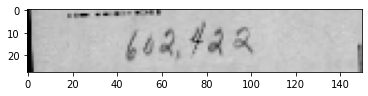

tensor([ 6,  0,  3, 10,  5,  8,  2], dtype=torch.int32)
min=0.00, max=0.76, mean=0.69, var=0.01, std=0.07


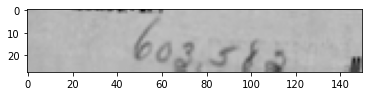

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  0, 10,  0,  7,  1], dtype=torch.int32)
min=-0.55, max=0.76, mean=0.68, var=0.01, std=0.11


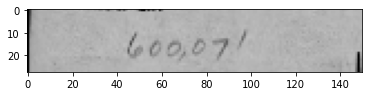

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  0, 10,  0,  0,  1], dtype=torch.int32)
min=-0.83, max=0.47, mean=0.33, var=0.04, std=0.20


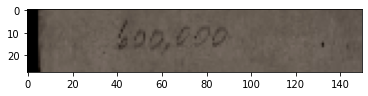

tensor([ 6,  0,  3, 10,  3,  2,  5], dtype=torch.int32)
min=0.18, max=0.75, mean=0.68, var=0.01, std=0.07


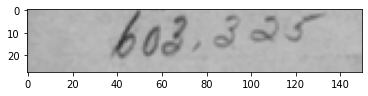

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  2, 10,  8,  5,  1], dtype=torch.int32)
min=-0.45, max=0.76, mean=0.67, var=0.01, std=0.11


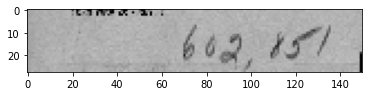

tensor([ 6,  0,  3, 10,  3,  9,  8], dtype=torch.int32)
min=0.02, max=0.72, mean=0.62, var=0.01, std=0.09


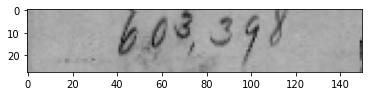

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  2, 10,  6,  8,  2], dtype=torch.int32)
min=-0.57, max=0.73, mean=0.63, var=0.01, std=0.11


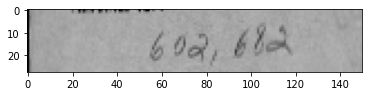

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  2, 10,  6,  0,  2], dtype=torch.int32)
min=-0.60, max=0.74, mean=0.65, var=0.01, std=0.11


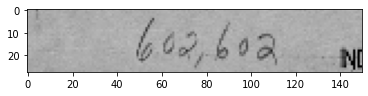

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  3, 10,  0,  7,  1], dtype=torch.int32)
min=-0.65, max=0.67, mean=0.50, var=0.09, std=0.29


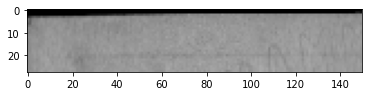

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  2, 10,  3,  2,  4], dtype=torch.int32)
min=-0.31, max=0.73, mean=0.63, var=0.01, std=0.11


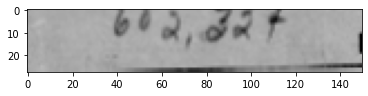

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  3, 10,  4,  0,  3], dtype=torch.int32)
min=-0.55, max=0.90, mean=0.67, var=0.05, std=0.23


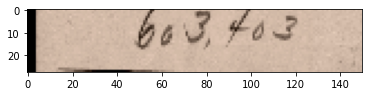

tensor([ 6,  0,  3, 10,  5,  1,  9], dtype=torch.int32)
min=-0.56, max=0.81, mean=0.66, var=0.03, std=0.17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


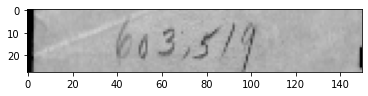

tensor([ 6,  0,  3, 10,  5,  5,  4], dtype=torch.int32)
min=0.11, max=0.75, mean=0.67, var=0.00, std=0.07


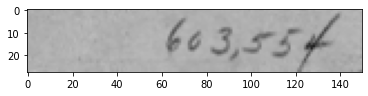

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  0, 10,  8,  1,  7], dtype=torch.int32)
min=-0.02, max=0.83, mean=0.74, var=0.01, std=0.08


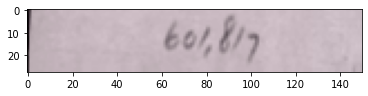

tensor([ 6,  0,  2, 10,  2,  3,  0], dtype=torch.int32)
min=0.26, max=0.91, mean=0.74, var=0.01, std=0.08


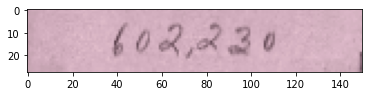

tensor([ 6,  0,  2, 10,  7,  5,  4], dtype=torch.int32)
min=0.21, max=0.74, mean=0.69, var=0.00, std=0.06


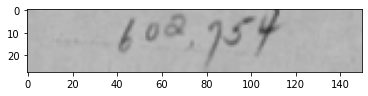

tensor([ 6,  0,  0, 10,  1,  6,  6], dtype=torch.int32)
min=0.18, max=0.73, mean=0.69, var=0.00, std=0.04


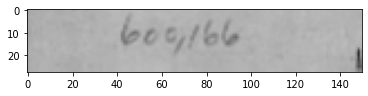

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  3, 10,  5,  1,  5], dtype=torch.int32)
min=-0.48, max=0.74, mean=0.66, var=0.01, std=0.11


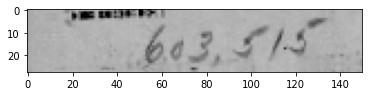

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  0, 10,  8,  5,  5], dtype=torch.int32)
min=-0.29, max=0.73, mean=0.67, var=0.01, std=0.09


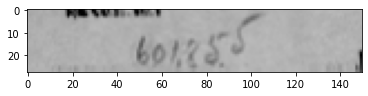

tensor([ 6,  0,  3, 10,  6,  9,  3], dtype=torch.int32)
min=0.05, max=0.65, mean=0.57, var=0.00, std=0.07


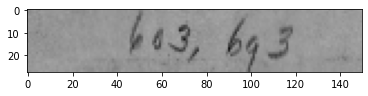

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  3, 10,  7,  5,  1], dtype=torch.int32)
min=-0.25, max=0.76, mean=0.65, var=0.01, std=0.10


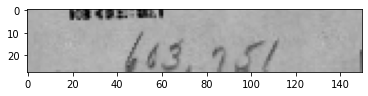

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  3, 10,  6,  7,  9], dtype=torch.int32)
min=-0.58, max=0.74, mean=0.66, var=0.03, std=0.18


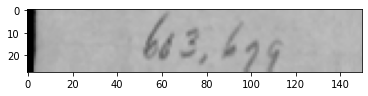

In [21]:
for k in range(32):
    print(data[1][k])
    statX(data[0][k])
    plt.imshow(data[0][k].permute(1,2,0))
    plt.show()

In [22]:
val_transform = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensor(),
])

In [23]:
val_set = WRAIDDataset(test_files, val_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [24]:
data = next(iter(val_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6,  0,  3, 10,  4,  0,  1], dtype=torch.int32)
min=-0.63, max=0.77, mean=0.63, var=0.04, std=0.21


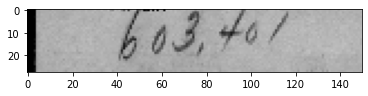

In [25]:
for k in range(1):
    print(data[1][k])
    statX(data[0][k])
    plt.imshow(data[0][k].permute(1,2,0))
    plt.show()

In [26]:
epochs = 50
num_classes = 12
blank_label = 11
image_height = 28
gru_hidden_size = 64
gru_num_layers = 2
cnn_output_height = 2
cnn_output_width = 16
digits_per_sequence = 7
number_of_sequences = 10000

In [27]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(5, 3), stride=2)
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [28]:
model = CRNN()

In [29]:
inp = torch.randn((1,3,28,150))
inp.shape

torch.Size([1, 3, 28, 150])

In [30]:
out = model(inp)

In [31]:
out.shape

torch.Size([1, 16, 12])

In [32]:
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
# ================================================ TRAINING MODEL ======================================================
best_correct = 0
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    model.train()
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        # x_train = x_train.view(x_train.shape[0], 1, x_train.shape[2], -1)
        
        optimizer.zero_grad()
        
        y_pred = model(x_train)
        
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        
        loss.backward()
        optimizer.step()
        
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    model.eval()
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        # x_val = x_val.view(x_val.shape[0], 1, x_val.shape[2], -1)
        with torch.set_grad_enabled(False):
            y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    # save best weights
    if val_correct > best_correct:
      best_correct = val_correct
      print("Best model seen, saving weights...")
    torch.save(model.state_dict(), "/content/gdrive/MyDrive/CRNN_ID.pth")
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

100%|██████████| 45/45 [00:08<00:00,  5.50it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 163.55it/s]
TESTING. Correct:  0 / 476 = 0.0
100%|██████████| 45/45 [00:08<00:00,  5.60it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 161.49it/s]
TESTING. Correct:  0 / 476 = 0.0
100%|██████████| 45/45 [00:07<00:00,  5.66it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 164.52it/s]
TESTING. Correct:  0 / 476 = 0.0
100%|██████████| 45/45 [00:08<00:00,  5.62it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 161.90it/s]
TESTING. Correct:  0 / 476 = 0.0
100%|██████████| 45/45 [00:07<00:00,  5.65it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 165.54it/s]
TESTING. Correct:  0 / 476 = 0.0
100%|██████████| 45/45 [00:08<00:00,  5.61it/s]
TRAINING. Correct:  0 / 1428 = 0.0
100%|██████████| 476/476 [00:02<00:00, 161.07it/s]
TESTING. Correct:  0 / 476 = 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


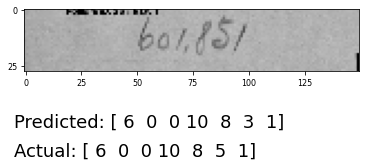

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


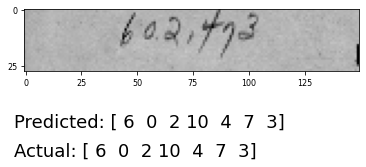

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


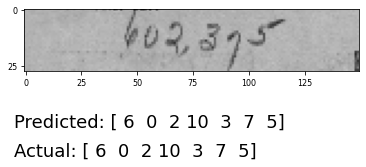

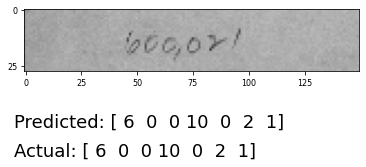

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


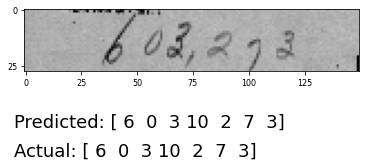

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


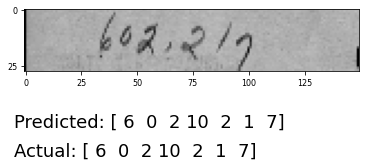

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


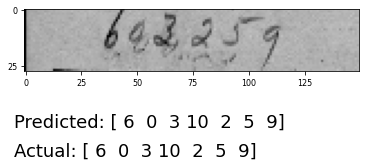

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


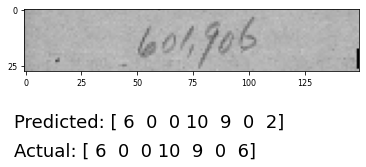

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


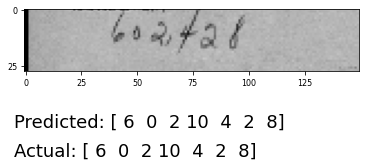

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


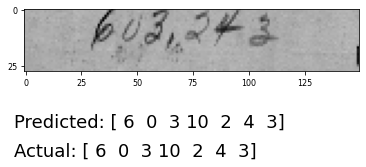

In [34]:
# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
#y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[2], -1).cuda())
with torch.no_grad():
    y_pred = model(x_test)

y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j].permute(1,2,0), cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()